In [ ]:
# | default_exp io

# IO module
> This module takes care of receiving the data catalogs.

In [ ]:
# | export
import matplotlib.image as mplimg
import pandas as pd
import pooch
from matplotlib import pyplot as plt
from yarl import URL

In [ ]:
# | export
logger = pooch.get_logger()
logger.setLevel("WARNING")

In [ ]:
# | export
base_url = URL("https://zenodo.org/record/8102805/files/")
urls = {
    "fans": "P4_catalog_v1.1_L1C_cut_0.5_fan.csv.zip",
    "blotches": "P4_catalog_v1.1_L1C_cut_0.5_blotch.csv.zip",
    "metadata": "P4_catalog_v1.1_metadata.csv.zip",
    "tile_coords": "P4_catalog_v1.1_tile_coords_final.csv.zip",
    "raw_data": "P4_catalog_v1.0_raw_classifications.hdf.zip",
    "intermediate": "P4_catalog_v1.0_pipeline_products.zip",
    "region_names": "region_names.zip",
    "tile_urls": "tile_urls.csv.zip",
}

In [ ]:
# | export

hashes = {
    "fans": "md5:71ff51ff79d6e975f704f19b1996d8ea",
    "blotches": "md5:f4d0c101f65abbaf34e092620133d56e",
    "metadata": "md5:c0dc46e0fc3d259c30afaec412074eae",
    "tile_coords": "md5:6b9a917a6997f1aa01cfef4322cabd81",
    "raw_data": "md5:39a8909590fe9f816454db93f0027d2c",
    "intermediate": "md5:6544bf0c7851eedd4783859c0adc42d7",
    "region_names": "md5:9101c7a0f8e248c9ffe9c07869da5635",
    "tile_urls": "md5:5717c8379d453cf4b11a5f5775f5fb6e",
}

In [ ]:
# | export


def _get_hash(key):
    url = URL(urls[key])
    path = pooch.retrieve(str(url), progressbar=True, known_hash=None)
    return pooch.file_hash(path)


def fetch_zipped_file(key):
    url = base_url / urls[key]
    hash = hashes[key]
    fpath = pooch.retrieve(
        str(url),
        path=pooch.os_cache("p4tools"),
        known_hash=hash,
        processor=pooch.Unzip(),
        progressbar=True,
    )
    return fpath[0]

In [ ]:
fetch_zipped_file("fans")

'/Users/maye/Library/Caches/p4tools/16b1d24add716ae8996bbfa0172b60ec-P4_catalog_v1.1_L1C_cut_0.5_fan.csv.zip.unzip/P4_catalog_v1.1_L1C_cut_0.5_fan.csv'

In [ ]:
# | export
def get_blotch_catalog() -> pd.DataFrame:
    return pd.read_csv(fetch_zipped_file("blotches"))


def get_fan_catalog() -> pd.DataFrame:
    return pd.read_csv(fetch_zipped_file("fans"))


def get_meta_data() -> pd.DataFrame:
    return pd.read_csv(fetch_zipped_file("metadata"))


def get_tile_coords() -> pd.DataFrame:
    return pd.read_csv(fetch_zipped_file("tile_coords"))


def get_region_names() -> pd.DataFrame:
    return pd.read_csv(fetch_zipped_file("region_names"))


def get_tile_urls() -> pd.DataFrame:
    return pd.read_csv(fetch_zipped_file("tile_urls"))

In [ ]:
fans = get_fan_catalog()

In [ ]:
fans.head()

,marking_id,angle,distance,tile_id,image_x,image_y,n_votes,obsid,spread,version,...,y_angle,l_s,map_scale,north_azimuth,BodyFixedCoordinateX,BodyFixedCoordinateY,BodyFixedCoordinateZ,PlanetocentricLatitude,PlanetographicLatitude,Longitude
0,F000000,205.56,179.71,APF0000ci9,2270.76,24336.16,35,ESP_012079_0945,88.03,1,...,-0.43,214.785,0.25,126.856883,-65.804336,261.407884,-3370.504345,-85.427383,-85.480829,104.129523
1,F000001,185.39,179.62,APF0000cia,3391.21,5640.60,15,ESP_012079_0945,21.35,1,...,-0.09,214.785,0.25,126.856883,-67.219114,257.011589,-3370.631413,-85.493546,-85.546226,104.656897
2,F000002,184.98,500.27,APF0000cia,3509.96,5876.70,10,ESP_012079_0945,18.91,1,...,-0.09,214.785,0.25,126.856883,-67.170611,257.055226,-3370.630794,-85.493039,-85.545725,104.644396
3,F000004,184.29,105.43,APF0000cia,3716.27,5824.50,6,ESP_012079_0945,26.41,1,...,-0.07,214.785,0.25,126.856883,-67.127761,257.024926,-3370.635002,-85.493723,-85.546401,104.637107
4,F000005,189.42,109.50,APF0000cia,3452.17,6033.00,3,ESP_012079_0945,22.58,1,...,-0.16,214.785,0.25,126.856883,-67.169940,257.096267,-3370.628302,-85.492368,-85.545061,104.642019


In [ ]:
get_region_names()

,obsid,lat_IND,lon_IND,roi_name,minimal_distance,lat_WORD,lon_WORD,time,MY
0,ESP_012079_0945,-85.4074,103.970,Macclesfield,0.944588,-85.401,103.901,2009-02-22 16:32:19,29
1,ESP_021494_0945,-85.4041,103.943,Macclesfield,0.511133,-85.401,103.901,2011-02-26 07:30:27,30
2,ESP_011407_0945,-85.4065,103.983,Macclesfield,0.957066,-85.401,103.901,2009-01-01 07:49:15,29
3,ESP_020782_0945,-85.4071,103.967,Macclesfield,0.901696,-85.401,103.901,2011-01-01 19:57:51,30
4,ESP_020716_0945,-85.4086,103.979,Macclesfield,1.098928,-85.401,103.901,2010-12-27 16:32:24,30
...,...,...,...,...,...,...,...,...,...
449,ESP_029762_0940,-85.7567,106.026,Manhattan2,0.782410,-85.751,105.971,2012-12-01 13:16:26,31
450,ESP_037977_0940,-85.6793,105.614,Manhattan2,8.544184,-85.751,105.971,2014-09-02 16:34:56,32
451,ESP_037976_0940,-85.6694,105.903,Manhattan2,9.131402,-85.751,105.971,2014-09-02 14:43:05,32
452,ESP_040311_0940,-85.7806,106.025,Manhattan2,3.335817,-85.751,105.971,2015-03-03 12:35:10,32


In [ ]:
# | export
def get_subframe(url):
    targetpath = pooch.retrieve(
        url, path=pooch.os_cache("p4tools/tiles"), known_hash=None, progressbar=True
    )
    im = mplimg.imread(targetpath)
    return im

In [ ]:
# | export
def get_url_for_tile_id(tile_id):
    return get_tile_urls().set_index("tile_id").squeeze().at[tile_id]

In [ ]:
tile_id = "APF0000ci9"

In [ ]:
get_url_for_tile_id(tile_id)

'http://www.planetfour.org/subjects/standard/50e7429f5e2ed21240003f52.jpg'

In [ ]:
# | export
def get_subframe_by_tile_id(tile_id):
    url = get_url_for_tile_id(tile_id)
    return get_subframe(url)

<matplotlib.image.AxesImage>

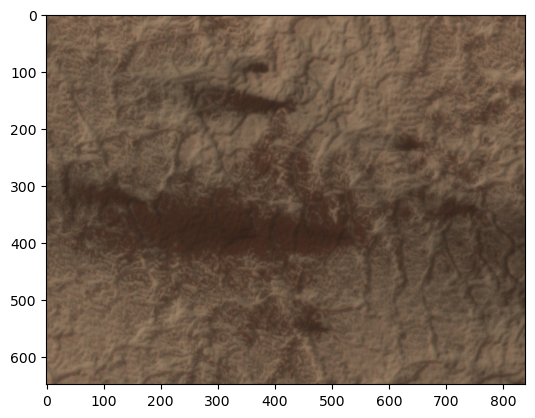

In [ ]:
plt.imshow(get_subframe_by_tile_id(tile_id))

In [ ]:
# | export
def get_fans_for_tile(tile_id):
    fans = get_fan_catalog()
    return fans.query("tile_id == @tile_id")

In [ ]:
get_fans_for_tile(tile_id)

,marking_id,angle,distance,tile_id,image_x,image_y,n_votes,obsid,spread,version,...,y_angle,l_s,map_scale,north_azimuth,BodyFixedCoordinateX,BodyFixedCoordinateY,BodyFixedCoordinateZ,PlanetocentricLatitude,PlanetographicLatitude,Longitude
1,F000001,185.39,179.62,APF0000cia,3391.21,5640.6,15,ESP_012079_0945,21.35,1,...,-0.09,214.785,0.25,126.856883,-67.219114,257.011589,-3370.631413,-85.493546,-85.546226,104.656897
2,F000002,184.98,500.27,APF0000cia,3509.96,5876.7,10,ESP_012079_0945,18.91,1,...,-0.09,214.785,0.25,126.856883,-67.170611,257.055226,-3370.630794,-85.493039,-85.545725,104.644396
3,F000004,184.29,105.43,APF0000cia,3716.27,5824.5,6,ESP_012079_0945,26.41,1,...,-0.07,214.785,0.25,126.856883,-67.127761,257.024926,-3370.635002,-85.493723,-85.546401,104.637107
4,F000005,189.42,109.50,APF0000cia,3452.17,6033.0,3,ESP_012079_0945,22.58,1,...,-0.16,214.785,0.25,126.856883,-67.169940,257.096267,-3370.628302,-85.492368,-85.545061,104.642019


In [ ]:
# | export
def get_blotches_for_tile(tile_id):
    blotches = get_blotch_catalog()
    return blotches.query("tile_id == @tile_id")

In [ ]:
blotches = get_blotches_for_tile(tile_id)

In [ ]:
blotches

,marking_id,angle,tile_id,image_x,image_y,n_votes,obsid,radius_1,radius_2,vote_ratio,...,y_angle,l_s,map_scale,north_azimuth,BodyFixedCoordinateX,BodyFixedCoordinateY,BodyFixedCoordinateZ,PlanetocentricLatitude,PlanetographicLatitude,Longitude


In [ ]:
# | export
def get_hirise_id_for_tile(tile_id):
    try:
        obsid = get_fan_catalog().query("tile_id == @tile_id").obsid.iloc[0]
    except IndexError:
        try:
            obsid = get_blotch_catalog().query("tile_id == @tile_id").obsid.iloc[0]
        except IndexError:
            raise ValueError(f"No obsid found for tile {tile_id}")
    else:
        return obsid

In [ ]:
get_hirise_id_for_tile(tile_id)

'ESP_012079_0945'